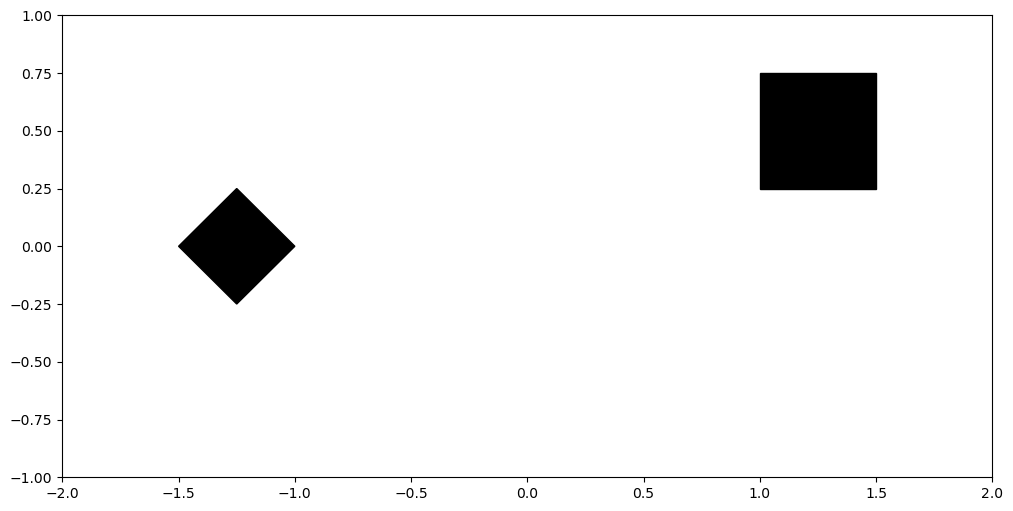

In [1]:
from sympy import Polygon
import matplotlib.pyplot as plt

environment = {'obstacles': [Polygon((1, 0.75), (1.5, 0.75), (1.5, 0.25), (1, 0.25)), Polygon(
    (-1.5, 0), (-1.25, 0.25), (-1, 0), (-1.25, -0.25))], 'x_range': (-2, 2), 'y_range': (-1, 1)}

fig, ax = plt.subplots(figsize=(12, 6))
for obstacle in environment['obstacles']:
    plt.fill([obstacle.vertices[i].x for i in range(len(obstacle.vertices))], [
        obstacle.vertices[i].y for i in range(len(obstacle.vertices))], color='black')

ax.set_xlim(environment['x_range'])
ax.set_ylim(environment['y_range'])

plt.show()


## Random Probabilistic Methods (RPM)

In [2]:
import numpy as np
from sympy.geometry import Point, Segment


def RPM_construct_graph(env, n_q, n_iter):

    def point_sampler(x_range, y_range):
        x = round(((x_range[1]-x_range[0]) *
                  np.random.random_sample() + x_range[0]), 3)
        y = round(((y_range[1]-y_range[0]) *
                  np.random.random_sample() + y_range[0]), 3)
        return Point(x, y)

    class graph_node():
        def __init__(self, point, connected_nodes):
            self.connected_nodes = connected_nodes
            self.point = point

        def __str__(self):
            return f'({self.point.x}, {self.point.y})'

    def in_obstacle(point, obstacles):
        for obstacle in obstacles:
            if obstacle.encloses_point(point):
                return True
        return False

    def line_intersect_obstacles(segment, obstacles):
        for obstacle in obstacles:
            if len(obstacle.intersection(segment)) != 0:
                return True
        return False

    graph = []
    for n_sample in range(n_iter):
        random_point = point_sampler(env['x_range'], env['y_range'])
        if in_obstacle(random_point, env['obstacles']):
            continue
        if len(graph) == 0:
            node = graph_node(random_point, connected_nodes=[])
            graph.append(node)
        elif len(graph) < n_q:
            closest_node = sorted(graph, key=lambda gn: gn.point.distance(
                random_point), reverse=False)[0]
            if line_intersect_obstacles(Segment(closest_node.point, random_point), env['obstacles']):
                continue
            new_node = graph_node(random_point, connected_nodes=[closest_node])
            closest_node.connected_nodes.append(new_node)
            graph.append(new_node)
        else:
            n_q_closest_nodes = sorted(graph, key=lambda gn: gn.point.distance(
                random_point), reverse=False)[:n_q]
            new_node = graph_node(random_point, connected_nodes=[])
            for closest_node in n_q_closest_nodes:
                if line_intersect_obstacles(Segment(closest_node.point, random_point), env['obstacles']):
                    continue
                new_node.connected_nodes.append(closest_node)
                closest_node.connected_nodes.append(new_node)
            if len(new_node.connected_nodes) > 0:
                graph.append(new_node)

    return graph


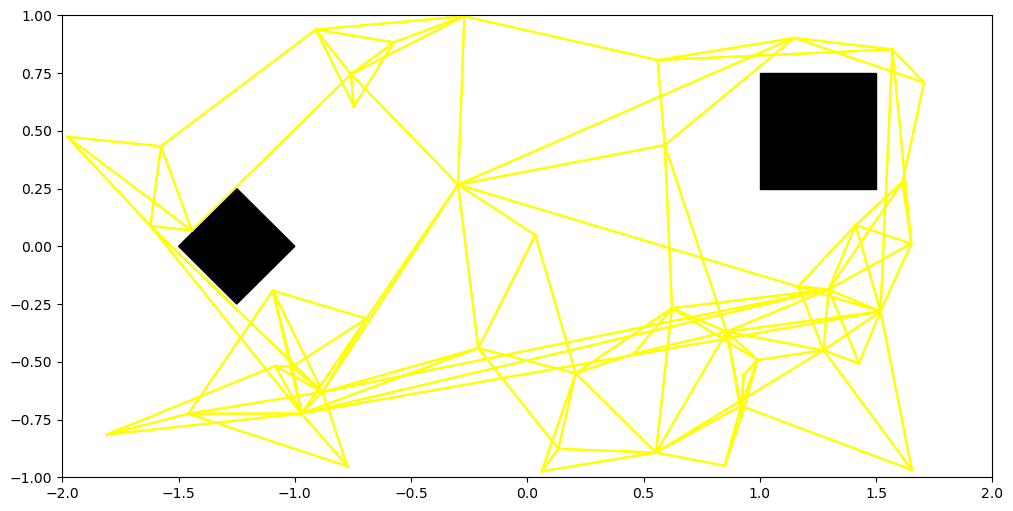

In [3]:
graph = RPM_construct_graph(environment, 3, 50)

seg_list = []
for node in graph:
    point = node.point
    for con_node in node.connected_nodes:
        con_point = con_node.point
        seg_list.append(Segment(con_point, point))

fig, ax = plt.subplots(figsize=(12, 6))

for obstacle in environment['obstacles']:
    plt.fill([obstacle.vertices[i].x for i in range(len(obstacle.vertices))], [
        obstacle.vertices[i].y for i in range(len(obstacle.vertices))], color='black')

for segment in seg_list:
    plt.plot([segment.p1.x, segment.p2.x], [
             segment.p1.y, segment.p2.y], color='yellow')

ax.set_xlim(environment['x_range'])
ax.set_ylim(environment['y_range'])

plt.show()


We then use Dijkstras Algorithm to find shortest path

## Rapidly Expanding Random Trees (RRT)

In [14]:
from sympy.geometry import Segment


def RRT_construct_graph(env, start_point, dt, n_iter):

    def point_sampler(x_range, y_range):
        x = round(((x_range[1]-x_range[0]) *
                  np.random.random_sample() + x_range[0]), 3)
        y = round(((y_range[1]-y_range[0]) *
                  np.random.random_sample() + y_range[0]), 3)
        return Point(x, y)

    class graph_node():
        def __init__(self, point, connected_nodes):
            self.connected_nodes = connected_nodes
            self.point = point

        def __str__(self):
            return f'({self.point.x}, {self.point.y})'

    def in_obstacle(point, obstacles):
        for obstacle in obstacles:
            if obstacle.encloses_point(point):
                return True
        return False

    def dt_point(new_point, nearest_point, dt):
        if new_point.distance(nearest_point)<=dt:
            return new_point
        v = [new_point.x-nearest_point.x , new_point.y-nearest_point.y]
        mod = (v[0]**2 + v[1]**2)**0.5
        v[0], v[1] = round(v[0]/mod, 3), round(v[1]/mod, 3)
        p1 = Point(nearest_point.x+dt*v[0], nearest_point.y+dt*v[0])
        p2 = Point(nearest_point.x-dt*v[0], nearest_point.y-dt*v[0])
        if p1.distance(new_point)<p2.distance(new_point):
            return p1
        return p2

    def line_intersect_obstacles(segment, obstacles):
        for obstacle in obstacles:
            if len(obstacle.intersection(segment)) != 0:
                return True
        return False

    graph = []
    graph.append(graph_node(start_point, connected_nodes=[]))
    for n_sample in range(n_iter):
        random_point = point_sampler(env['x_range'], env['y_range'])
        if in_obstacle(random_point, env['obstacles']):
            continue
        closest_node = sorted(graph, key=lambda gn: gn.point.distance(
            random_point), reverse=False)[0]
        new_point = dt_point(random_point, closest_node.point , dt)
        
        if line_intersect_obstacles(Segment(closest_node.point, new_point), env['obstacles']):
            continue

        new_node = graph_node(new_point, connected_nodes=[closest_node])
        closest_node.connected_nodes.append(new_node)
        graph.append(new_node)
        
    return graph


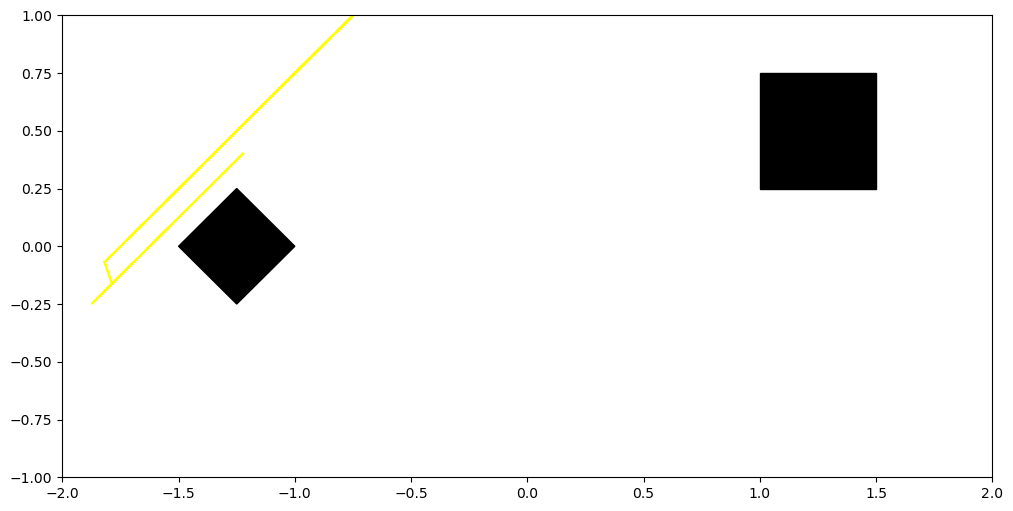

In [24]:
graph = RRT_construct_graph(environment, Point(-1.75,0), 0.1, 100)

seg_list = []
for node in graph:
    point = node.point
    for con_node in node.connected_nodes:
        con_point = con_node.point
        seg_list.append(Segment(con_point, point))

fig, ax = plt.subplots(figsize=(12, 6))

for obstacle in environment['obstacles']:
    plt.fill([obstacle.vertices[i].x for i in range(len(obstacle.vertices))], [
        obstacle.vertices[i].y for i in range(len(obstacle.vertices))], color='black')

for segment in seg_list:
    plt.plot([segment.p1.x, segment.p2.x], [
             segment.p1.y, segment.p2.y], color='yellow')

ax.set_xlim(environment['x_range'])
ax.set_ylim(environment['y_range'])

plt.show()
